In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import time 

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [2]:
train_dir = 'data3a/training' 
val_dir = 'data3a/validation'

In [3]:
img_width, img_height = 150, 150

In [4]:
epoch = 50
batch_size=16

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


In [7]:
densenet121_model = Sequential()
pretrained_model = DenseNet121(
    include_top=False,
    input_shape=(img_width, img_height, 3),
    pooling='max',
    classes=3,
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable=False
    
densenet121_model.add(pretrained_model)
densenet121_model.add(Flatten())
densenet121_model.add(Dense(512, activation='relu'))
# minor moderate and severe (3)
densenet121_model.add(Dense(3, activation='softmax'))

In [8]:
#Model compile
densenet121_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import CSVLogger

# Define the CSVLogger

log_folder = "traininglog"
log_file_path = f"{log_folder}/densenet121_training_log.csv"

csv_logger = CSVLogger(log_file_path, append=True)

In [10]:
set_epoch=50
#Model Train 
start_time = time.time()

# Train the model and pass the CSVLogger as a callback
history = densenet121_model.fit(train_generator, epochs=set_epoch, validation_data=val_generator,callbacks=[csv_logger])

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Total training time: {elapsed_time:.2f} seconds")


Epoch 1/50
87/87 [==============================] - 67s 705ms/step - loss: 2.0582 - accuracy: 0.4946 - val_loss: 0.8447 - val_accuracy: 0.6129
Epoch 2/50
87/87 [==============================] - 60s 690ms/step - loss: 0.9593 - accuracy: 0.5813 - val_loss: 0.8112 - val_accuracy: 0.6331
Epoch 3/50
87/87 [==============================] - 60s 687ms/step - loss: 0.8710 - accuracy: 0.5936 - val_loss: 0.8650 - val_accuracy: 0.6048
Epoch 4/50
87/87 [==============================] - 60s 685ms/step - loss: 0.8386 - accuracy: 0.6045 - val_loss: 0.9466 - val_accuracy: 0.5524
Epoch 5/50
87/87 [==============================] - 59s 681ms/step - loss: 0.8819 - accuracy: 0.5965 - val_loss: 0.8945 - val_accuracy: 0.5645
Epoch 6/50
87/87 [==============================] - 59s 681ms/step - loss: 0.8172 - accuracy: 0.6023 - val_loss: 0.8272 - val_accuracy: 0.5968
Epoch 7/50
87/87 [==============================] - 61s 703ms/step - loss: 0.8165 - accuracy: 0.6146 - val_loss: 0.7011 - val_accuracy: 0.7016

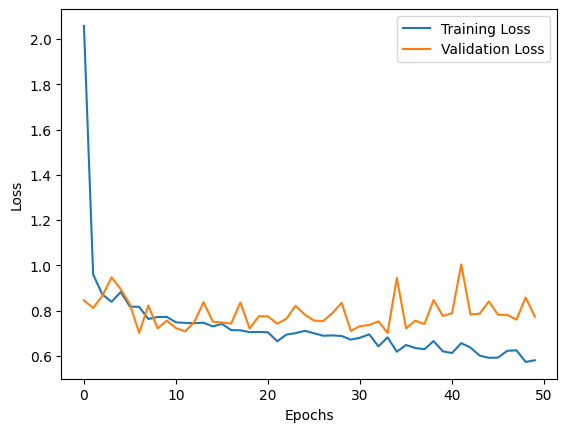

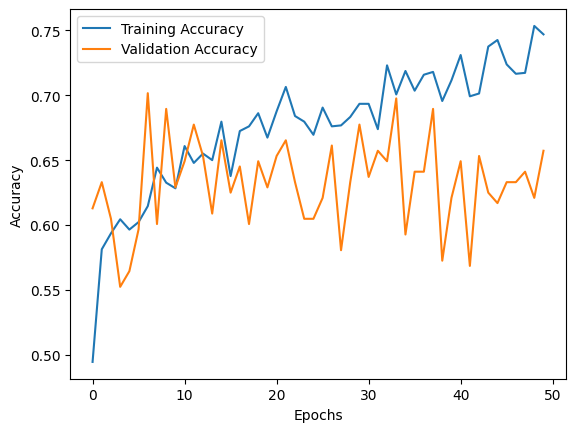

In [11]:
import matplotlib.pyplot as plt
# loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
from sklearn.metrics import f1_score
# # f1 score
# plt.plot(history.history['f1_score'], label='Training F1 Score')
# plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()

8/8 [==============================] - 8s 750ms/step
Confusion Matrix:


C:\Users\sandi\AppData\Local\Temp\ipykernel_6776\3449477194.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45) #predicted
C:\Users\sandi\AppData\Local\Temp\ipykernel_6776\3449477194.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['minor', 'moderate', 'severe']) #actual


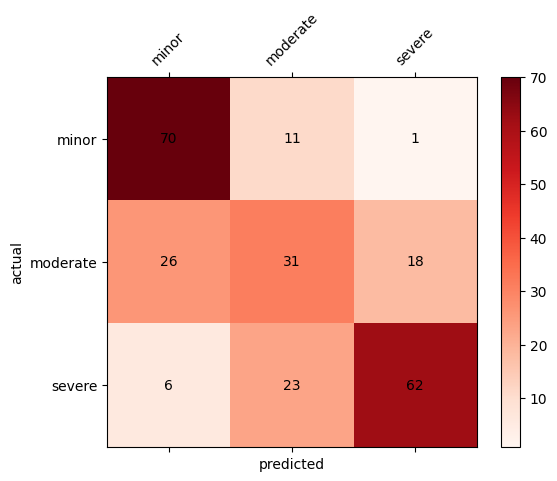

Classification Report:
              precision    recall  f1-score   support

    01-minor       0.69      0.85      0.76        82
 02-moderate       0.48      0.41      0.44        75
   03-severe       0.77      0.68      0.72        91

    accuracy                           0.66       248
   macro avg       0.64      0.65      0.64       248
weighted avg       0.65      0.66      0.65       248



In [12]:
import numpy as np
val_images, val_labels = [], []
class_names = sorted(train_generator.class_indices.keys())
for i in range(len(val_generator)):
    images, labels = val_generator[i]
    val_images.extend(images)
    val_labels.extend(np.argmax(labels, axis=1))


val_images = np.array(val_images)
val_labels = np.array(val_labels)

predictions = densenet121_model.predict(val_images)



from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(predictions, axis=1)
y_true = val_labels

confusion_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xlabel('predicted') #predicted
ax.set_ylabel('actual') #actual

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45) #predicted
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe']) #actual

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center')
print('Confusion Matrix:')

plt.show()



report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

In [13]:
densenet121_model.save('models/densenet121-model-bs16-ep50.keras')
print('model saved')

model saved


1/1 [==============================] - 0s 79ms/step


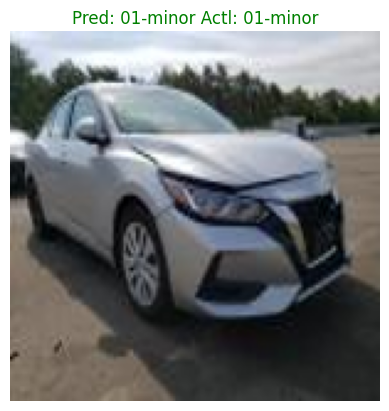

1/1 [==============================] - 0s 76ms/step


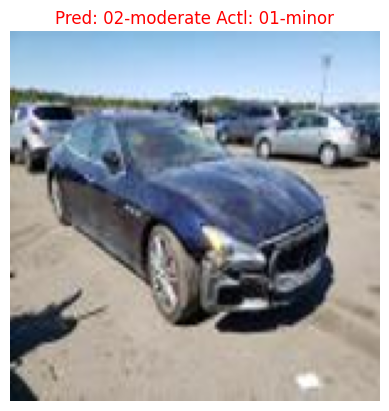

1/1 [==============================] - 0s 67ms/step


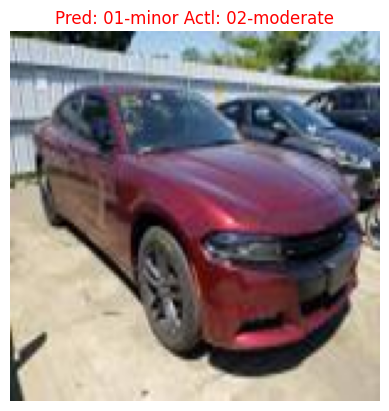

1/1 [==============================] - 0s 76ms/step


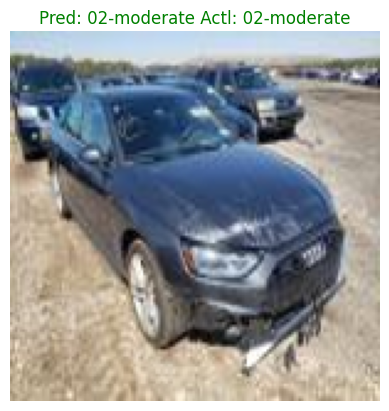

1/1 [==============================] - 0s 67ms/step


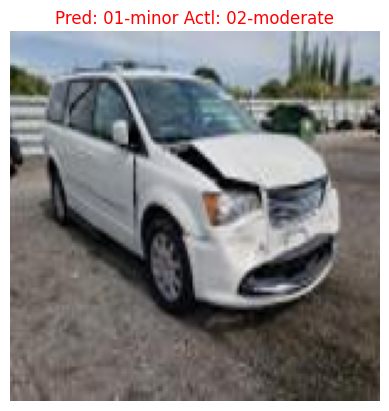

1/1 [==============================] - 0s 67ms/step


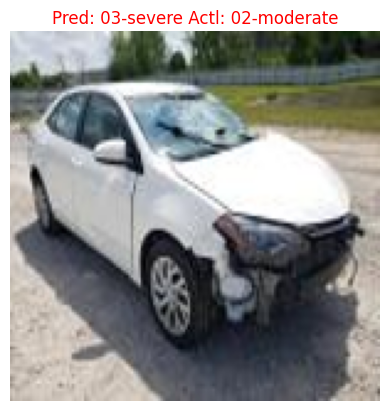

1/1 [==============================] - 0s 78ms/step


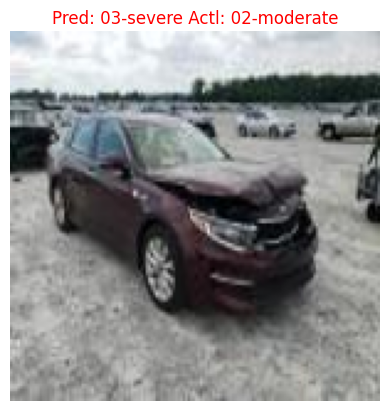

1/1 [==============================] - 0s 88ms/step


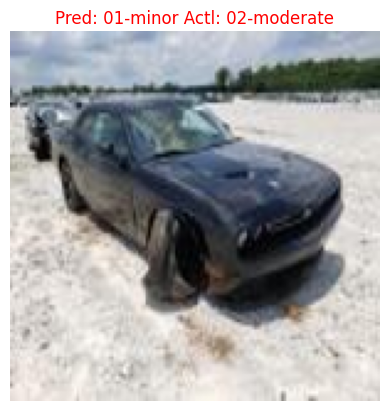

1/1 [==============================] - 0s 66ms/step


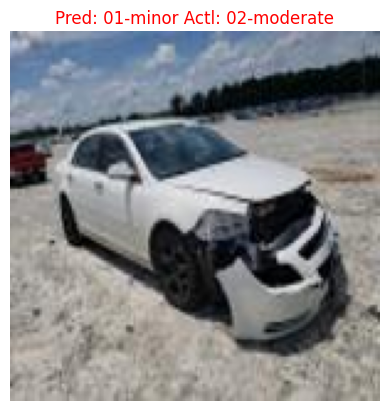

1/1 [==============================] - 0s 89ms/step


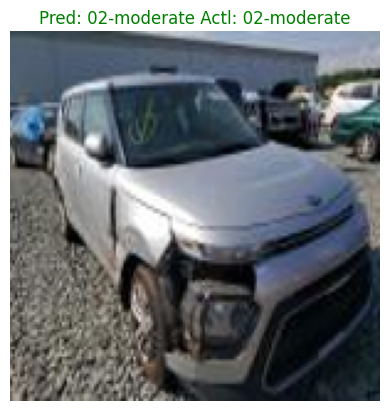

1/1 [==============================] - 0s 66ms/step


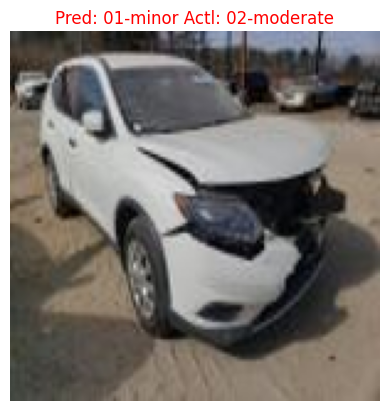

1/1 [==============================] - 0s 66ms/step


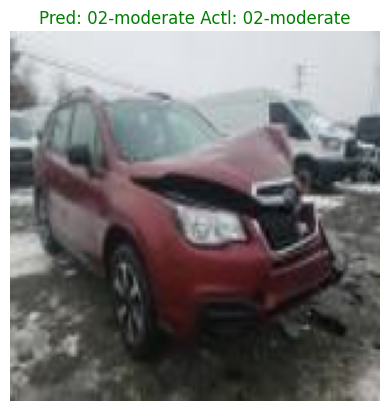

1/1 [==============================] - 0s 87ms/step


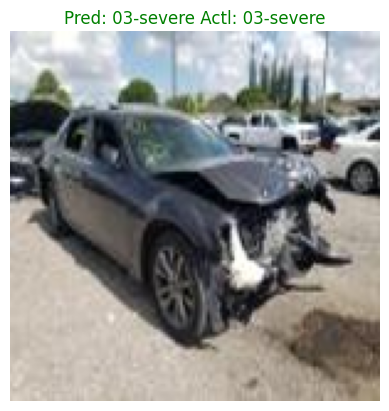

1/1 [==============================] - 0s 68ms/step


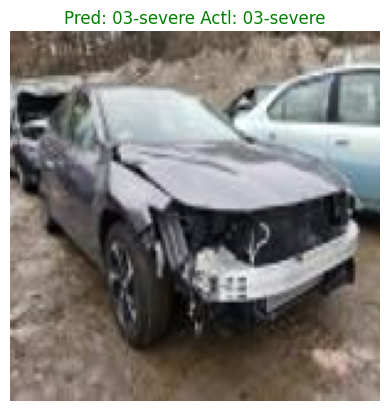

1/1 [==============================] - 0s 66ms/step


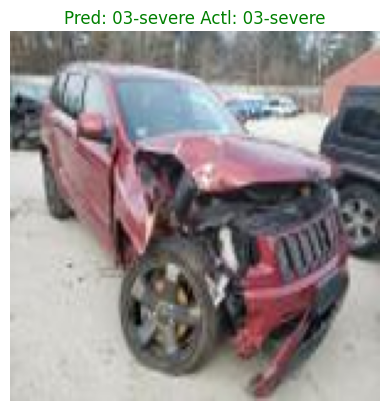

1/1 [==============================] - 0s 56ms/step


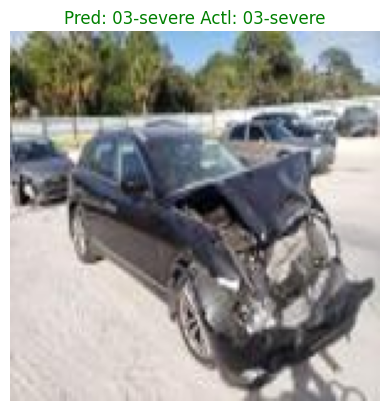

1/1 [==============================] - 0s 55ms/step


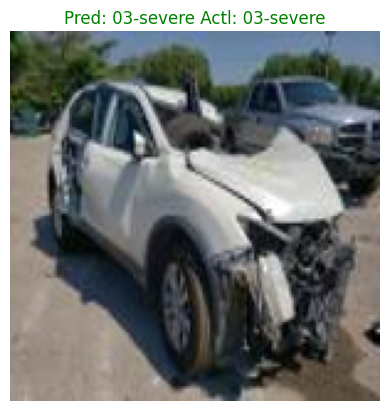

1/1 [==============================] - 0s 76ms/step


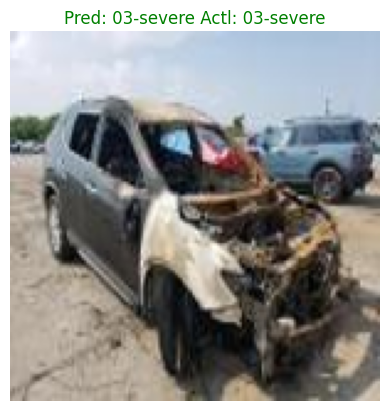

1/1 [==============================] - 0s 66ms/step


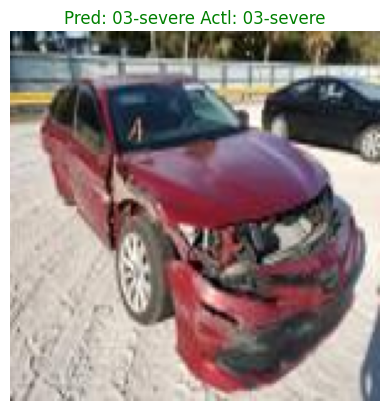

1/1 [==============================] - 0s 90ms/step


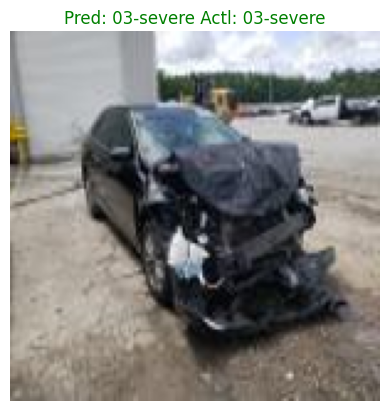

1/1 [==============================] - 0s 90ms/step


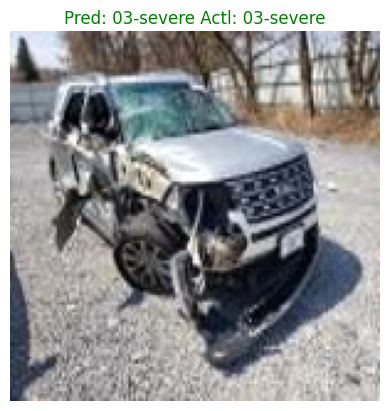

1/1 [==============================] - 0s 76ms/step


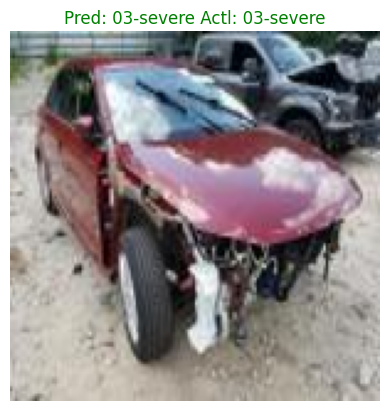

False: 8
True: 14


In [14]:
val_dir = 'data3a/validation'
class_names = ["01-minor", "02-moderate", "03-severe"]

image_paths = []
for class_name in class_names:
    folder_path = os.path.join(val_dir, class_name)
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(folder_path, filename))
negative = 0
positive = 0
for image_path in image_paths:
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = img.resize((img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)
    pred = densenet121_model.predict(img)
    pred_label = class_names[np.argmax(pred)]
    folder_name = os.path.basename(os.path.dirname(image_path))
    plt.imshow(img[0])
    if (pred_label != folder_name):
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'red')
        negative+=1
    else:
        plt.title('Pred: ' + pred_label + ' Actl: ' + folder_name, color = 'green')
        positive+=1
   
    plt.axis('off')
    plt.show() 
print('False: '+ str(negative) + '\nTrue: ' + str(positive))